In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import boto3

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket='sagemaker-us-east-2-840691022453', Key='Udacity_MAILOUT_052018_TEST.csv')
mail_df = pd.read_csv(obj['Body'], sep=";")

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
mail_df.shape

(42833, 366)

In [5]:
mail_df.columns

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=366)

In [7]:
mail_df_train = pd.read_csv('data/mail_df_selected_before_scaling.csv')
mail_df_train = mail_df_train.drop('Unnamed: 0', axis=1)

In [8]:
mail_df_train.columns

Index(['ANZ_PERSONEN', 'ANZ_TITEL', 'BALLRAUM', 'CJT_GESAMTTYP',
       'D19_BANKEN_DATUM', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_KONSUMTYP',
       ...
       'CAMEO_DEU_2015_7E', 'CAMEO_DEU_2015_8A', 'CAMEO_DEU_2015_8B',
       'CAMEO_DEU_2015_8C', 'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A',
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E'],
      dtype='object', length=271)

In [12]:
to_remove = list(set(mail_df.columns)-set(mail_df_train.columns))

In [13]:
len(to_remove)

149

In [14]:
'CAMEO_DEU_2015' in to_remove

True

In [15]:
'CAMEO_DEUG_2015' in to_remove

True

In [16]:
'OST_WEST_KZ' in to_remove

False

In [17]:
'OST_WEST_KZ' in mail_df_train.columns

True

In [18]:
'OST_WEST_KZ' in mail_df.columns

True

In [22]:
to_remove.index('CAMEO_DEU_2015'), to_remove.index('CAMEO_DEUG_2015')

(90, 42)

In [25]:
to_remove.pop(42)

'CAMEO_DEUG_2015'

In [26]:
to_remove.index('CAMEO_DEU_2015')

89

In [27]:
to_remove.pop(89)

'CAMEO_DEU_2015'

In [28]:
len(to_remove)

147

In [29]:
mail_df.shape

(42833, 366)

In [30]:
test_df = mail_df.drop(to_remove, axis=1)

In [31]:
test_df.shape

(42833, 219)

In [32]:
# Finding categories of CAMEO_DEU_2015
CAMEO_DEU_2015_vals = []
for c in test_df['CAMEO_DEU_2015']:
    if c not in CAMEO_DEU_2015_vals:
        CAMEO_DEU_2015_vals.append(c)
print(CAMEO_DEU_2015_vals)
print(len(CAMEO_DEU_2015_vals))

['2B', '5A', '7A', '9D', '4E', '6B', '2D', '1D', '7E', '4C', nan, '1C', '4A', '5F', '6D', '3C', '9B', '6C', '8B', '3D', '5D', '1A', '3A', '7B', '2C', '8A', '6F', '2A', '5B', '6E', '5C', '8D', '4D', '8C', '9E', '7C', '9A', '6A', '9C', '1B', '3B', '7D', '1E', 'XX', '4B', '5E']
46


In [34]:
#Converting the 'XX' to NaN
test_df['CAMEO_DEU_2015'] = np.where((test_df['CAMEO_DEU_2015'] == 'XX'), np.nan, test_df['CAMEO_DEU_2015'])
test_df['CAMEO_DEU_2015'][test_df['CAMEO_DEU_2015']=='XX']  # verifying if the substitution worked

Series([], Name: CAMEO_DEU_2015, dtype: object)

In [37]:
# Finding categories of CAMEO_DEUG_2015
CAMEO_DEUG_2015_vals = []
for i in range(len(test_df['CAMEO_DEUG_2015'])):
    c = test_df['CAMEO_DEUG_2015'][i]
    if c not in CAMEO_DEUG_2015_vals:
        CAMEO_DEUG_2015_vals.append(c)

In [39]:
#converting 'X' to NaN
test_df['CAMEO_DEUG_2015'] = np.where((test_df['CAMEO_DEUG_2015'] == 'X'), np.nan, test_df['CAMEO_DEUG_2015'])

In [40]:
test_df.shape

(42833, 219)

In [41]:
# Fix the categories for CAMEO_DEUG_2015 such as 1 and 1.0 are the same
for i in range(len(test_df['CAMEO_DEUG_2015'])):
    try:
        if not np.isnan(test_df['CAMEO_DEUG_2015'][i]):
            test_df['CAMEO_DEUG_2015'][i] = int(test_df['CAMEO_DEUG_2015'][i])
        else:
            test_df['CAMEO_DEUG_2015'][i] = np.nan
    except TypeError:
        test_df['CAMEO_DEUG_2015'][i] = int(float(str(test_df['CAMEO_DEUG_2015'][i])))

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


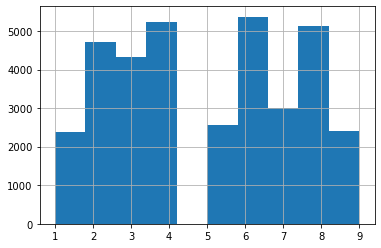

In [42]:
test_df['CAMEO_DEUG_2015'].hist()

In [43]:
'RESPONSE' in test_df.columns

False

In [44]:
# Finding categories of OST_WEST_KZ
OST_WEST_KZ_vals = []
for i in range(len(test_df['OST_WEST_KZ'])):
    c = test_df['OST_WEST_KZ'][i]
    try:
        if str(int(c)) not in OST_WEST_KZ_vals:
            OST_WEST_KZ_vals.append(str(int(c)))
    except ValueError:
        if str(c) not in OST_WEST_KZ_vals:
            OST_WEST_KZ_vals.append(str(c))
print(sorted(OST_WEST_KZ_vals))
print(len(OST_WEST_KZ_vals))

['O', 'W', 'nan']
3


In [46]:
# Lets binary encode the 'OST_WEST_KZ' column
test_df['OST_WEST_KZ'] = np.where((test_df['OST_WEST_KZ'] == 'O'), 0, test_df['OST_WEST_KZ'])
test_df['OST_WEST_KZ'] = np.where((test_df['OST_WEST_KZ'] == 'W'), 1, test_df['OST_WEST_KZ'])

In [47]:
test_df['OST_WEST_KZ']

0          1
1          1
2          1
3          0
4          1
        ... 
42828    NaN
42829      1
42830      1
42831      1
42832      1
Name: OST_WEST_KZ, Length: 42833, dtype: object

In [48]:
# Lets one hot encode CAMEO_DEUG_2015
test_df = pd.concat([test_df, pd.get_dummies(test_df['CAMEO_DEUG_2015'], prefix='CAMEO_DEUG_2015',dummy_na=True)],axis=1).drop(['CAMEO_DEUG_2015'], axis=1)

In [49]:
for c in test_df.columns:
    if c.startswith('CAMEO_DEUG_2015'):
        print(c, end=',')

CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_nan,

In [50]:
# Lets drop the CAMEO_DEUG_2015_nan column
test_df = test_df.drop('CAMEO_DEUG_2015_nan', axis=1)

In [51]:
# Lets one-hot encode CAMEO_DEU_2015 column
test_df = pd.concat([test_df, pd.get_dummies(test_df['CAMEO_DEU_2015'], prefix='CAMEO_DEU_2015',dummy_na=True)],axis=1).drop(['CAMEO_DEU_2015'],axis=1)

In [52]:
# Lets drop the CAMEO_DEU_2015_nan column
test_df = test_df.drop('CAMEO_DEU_2015_nan', axis=1)

In [54]:
test_df.shape

(42833, 270)

In [55]:
# Imputing using the most frequent value in the column
test_df = test_df.fillna(test_df.mode().iloc[0])

In [56]:
test_df.head(n=10)

,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_KONSUMTYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,2.0,0.0,6.0,5.0,10,1,4,8,4,3.0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0.0,7.0,1.0,10,0,9,9,10,3.0,...,0,0,0,0,0,0,0,0,0,0
2,4.0,0.0,1.0,2.0,10,0,10,10,10,9.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,1.0,4.0,10,0,8,8,8,9.0,...,0,0,0,0,0,0,0,0,0,0
4,4.0,0.0,6.0,6.0,2,4,2,3,2,1.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,0.0,1.0,1.0,10,0,7,7,10,9.0,...,0,0,0,0,0,0,0,0,1,0
6,2.0,0.0,6.0,2.0,10,4,1,1,2,1.0,...,0,0,0,0,0,0,0,0,0,0
7,4.0,0.0,3.0,2.0,10,1,2,8,9,2.0,...,0,0,0,0,0,0,0,0,0,0
8,4.0,0.0,3.0,1.0,7,5,1,6,1,1.0,...,0,0,0,0,0,0,0,0,0,0
9,1.0,0.0,2.0,1.0,9,3,2,9,2,1.0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
test_df.to_csv('data/test_df_before_scaling.csv')

In [59]:
test_df.shape

(42833, 270)

In [58]:
# Lets scale this dataframe before applying model
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [60]:
test_df_scaled = pd.DataFrame(np.zeros(test_df.shape), columns = test_df.columns)
test_df_scaled[test_df.columns] = scaler.fit_transform(test_df)

In [61]:
test_df_scaled.columns

Index(['ANZ_PERSONEN', 'ANZ_TITEL', 'BALLRAUM', 'CJT_GESAMTTYP',
       'D19_BANKEN_DATUM', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_KONSUMTYP',
       ...
       'CAMEO_DEU_2015_7E', 'CAMEO_DEU_2015_8A', 'CAMEO_DEU_2015_8B',
       'CAMEO_DEU_2015_8C', 'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A',
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E'],
      dtype='object', length=270)

In [62]:
test_df_scaled.head(n=10)

,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_KONSUMTYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,0.142857,0.0,0.833333,0.8,1.000000,0.166667,0.333333,0.777778,0.333333,0.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.071429,0.0,1.000000,0.0,1.000000,0.000000,0.888889,0.888889,1.000000,0.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.285714,0.0,0.000000,0.2,1.000000,0.000000,1.000000,1.000000,1.000000,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.6,1.000000,0.000000,0.777778,0.777778,0.777778,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.285714,0.0,0.833333,1.0,0.111111,0.666667,0.111111,0.222222,0.111111,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.071429,0.0,0.000000,0.0,1.000000,0.000000,0.666667,0.666667,1.000000,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.142857,0.0,0.833333,0.2,1.000000,0.666667,0.000000,0.000000,0.111111,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.285714,0.0,0.333333,0.2,1.000000,0.166667,0.111111,0.777778,0.888889,0.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.285714,0.0,0.333333,0.0,0.666667,0.833333,0.000000,0.555556,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.071429,0.0,0.166667,0.0,0.888889,0.500000,0.111111,0.888889,0.111111,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
test_df_scaled.to_csv('data/test_df_scaled.csv', header=False, index=False)

In [65]:
test_df_scaled.head(n=10)

,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_KONSUMTYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,0.142857,0.0,0.833333,0.8,1.000000,0.166667,0.333333,0.777778,0.333333,0.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.071429,0.0,1.000000,0.0,1.000000,0.000000,0.888889,0.888889,1.000000,0.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.285714,0.0,0.000000,0.2,1.000000,0.000000,1.000000,1.000000,1.000000,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.6,1.000000,0.000000,0.777778,0.777778,0.777778,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.285714,0.0,0.833333,1.0,0.111111,0.666667,0.111111,0.222222,0.111111,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.071429,0.0,0.000000,0.0,1.000000,0.000000,0.666667,0.666667,1.000000,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.142857,0.0,0.833333,0.2,1.000000,0.666667,0.000000,0.000000,0.111111,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.285714,0.0,0.333333,0.2,1.000000,0.166667,0.111111,0.777778,0.888889,0.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.285714,0.0,0.333333,0.0,0.666667,0.833333,0.000000,0.555556,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.071429,0.0,0.166667,0.0,0.888889,0.500000,0.111111,0.888889,0.111111,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
t = pd.read_csv('data/test_df_scaled.csv') # testing if the serialization worked

In [67]:
t

,0.14285714285714285,0.0,0.8333333333333334,0.8,1.0,0.16666666666666666,0.3333333333333333,0.7777777777777777,0.3333333333333333.1,0.25,...,0.0.69,0.0.70,0.0.71,0.0.72,0.0.73,0.0.74,0.0.75,0.0.76,0.0.77,0.0.78
0,0.071429,0.000000,1.000000,0.0,1.000000,0.000000,0.888889,0.888889,1.000000,0.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.285714,0.000000,0.000000,0.2,1.000000,0.000000,1.000000,1.000000,1.000000,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.6,1.000000,0.000000,0.777778,0.777778,0.777778,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.285714,0.000000,0.833333,1.0,0.111111,0.666667,0.111111,0.222222,0.111111,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.071429,0.000000,0.000000,0.0,1.000000,0.000000,0.666667,0.666667,1.000000,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42827,0.071429,0.000000,0.833333,1.0,1.000000,0.000000,1.000000,1.000000,1.000000,0.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42828,0.071429,0.000000,0.833333,0.2,1.000000,0.000000,1.000000,1.000000,1.000000,0.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42829,0.214286,0.000000,0.833333,0.4,0.888889,0.166667,0.444444,0.777778,0.555556,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42830,0.071429,0.000000,0.833333,0.8,1.000000,0.000000,0.555556,0.888889,0.555556,0.625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
